## Figure notebook for annotating single-nuclei RNA-seq datasets (from neurips 2021, S1D1 multiome)

Last updated: 12/21/2022
Author: Yang-Joon Kim

Notse: 
- We will use the neurips 2021, s1d1 (RNA+ATAC) objects, only for the RNA part.
- We will use a subset of cell-types for UMAP visualizations for simplicity



In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sys

In [115]:
# load utilities module
sys.path.append("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/excellxgene_tutorials/utilities/")
import color_schema

In [118]:
mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')

In [112]:
# define the figure path
figpath = "/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/excellxgene_tutorials/figures/Figure_RNA_knownCelltype_markers/"
sc.settings.figdir = figpath
set_plotting_style()

In [4]:
filepath = "/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/"
adata = sc.read_h5ad(filepath + "s1d1_rna_atac_joint.h5ad")
adata

AnnData object with n_obs × n_vars = 6224 × 36852
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'rna_ann', 'cell_type_RNA', 'cell_type_ATAC'
    var: 'assay'
    obsm: 'X_pca', 'X_umap_ATAC', 'X_umap_RNA'
    obsp: 'connectivities', 'distances'

## Figure scheme

- (A): UMAP embedding (with leiden clustering)
- (B): schematics showing the dictionary of cell-types: marker genes
- (C): UMAP with marker genes for a couple of cell-types
- (D): histogram to filter out some noisy cells
- (E): sub-clustering for making a child UMAP


**Which annotation to be used per celltype**

(Plotting specific marker genes for clarification below)

From RNA:
- CD14+ Mono
- ID2-hi myeloid prog
- CD16+ Mono
- NK
- ILC
- cDC2
- Reticulocyte
- Erythroblast
- Proerythroblast
- HSC

From ATAC:
- CD4+ T activated
- CD4+ T naive
- CD8+ T
- Lymph prog
- naive CD20+ B
- B1 B
- Transitional B
- pDCs
- G/M prog: ('HSPC' in ATAC)
- MK/E prog
- Plasma cells


Notes:


In [5]:
adata

AnnData object with n_obs × n_vars = 6224 × 36852
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'rna_ann', 'cell_type_RNA', 'cell_type_ATAC'
    var: 'assay'
    obsm: 'X_pca', 'X_umap_ATAC', 'X_umap_RNA'
    obsp: 'connectivities', 'distances'

In [6]:
# edit the gene names as we've added "-RNA" or "-ATAC" to merge the two modalities
#RNA
marker_genes_rna = {
    'CD14+ Mono': ['FCN1', 'CD14'],
    'CD16+ Mono': ['TCF7L2', 'FCGR3A', 'LYN'],
    'ID2-hi myeloid prog': ['CD14', 'ID2', 'VCAN', 'S100A9', 'CLEC12A', 'KLF4', 'PLAUR'],
    'cDC1': ['CLEC9A', 'CADM1'],
    'cDC2': ['CLEC10A', 'FCER1A', 'CST3', 'COTL1', 'LYZ', 'DMXL2'], # Note: DMXL2 should be negative
    'Reticulocyte': ['SLC4A1', 'SLC25A37', 'HBB', 'HBA2', 'HBA1', 'TFRC'],
    'Erythroblast': ['MKI67', 'HBA1', 'HBB'],
    'Proerythroblast': ['CDK6', 'SYNGR1', 'HBM', 'GYPA'], # Note HBM and GYPA are negative markers
    'NK': ['GNLY', 'NKG7', 'CD247', 'GRIK4', 'FCER1G', 'TYROBP', 'KLRG1', 'FCGR3A'],
    'ILC': ['ID2', 'PLCG2', 'GNLY', 'SYNE1'],
    'Lymph prog': ['IGLL1', 'VPREB1', 'MME', 'EBF1', 'SSBP2', 'BACH2', 'CD79B', 'IGHM', 'PAX5', 'PRKCE', 'DNTT'],
    'Naive CD20+ B': ['MS4A1', 'IL4R', 'IGHD', 'FCRL1', 'IGHM'],
    'B1 B': ['MS4A1', 'SSPN', 'ITGB1', 'EPHA4', 'COL4A4', 'PRDM1', 'ZNF215', 'IRF4', 'CD38', 'XBP1', 'PAX5', 'BCL11A', 'BLK', 'IGHD', 'IGHM'], # Note IGHD and IGHM are negative markers
    'Transitional B': ['MME', 'CD38', 'CD24', 'ACSM3', 'MSI2'],
    'Plasma cells': ['MZB1', 'HSP90B1', 'FNDC3B', 'PRDM1', 'IGKC', 'JCHAIN'],
    'Plasmablast': ['XBP1', 'RF4', 'PRDM1', 'PAX5'],  # Note PAX5 is a negative marker
    'CD4+ T activated': ['CD4', 'IL7R', 'TRBC2', 'ITGB1'],
    'CD4+ T naive': ['CD4', 'IL7R', 'TRBC2', 'CCR7'],
    'CD8+ T': ['CD8A', 'CD8B', 'GZMB', 'GZMA', 'CCL5', 'GZMK', 'GZMH', 'GZMA'],
    'T activation': ['CD69', 'CD38'], # CD69 much better marker!
    'T naive': ['LEF1', 'CCR7', 'TCF7'],
    'pDCs': ['GZMB', 'IL3RA', 'COBLL1', 'TCF4'],
    'G/M prog': ['MPO', 'BCL2', 'KCNQ5', 'CSF3R', 'PRTN3'],
    'HSC': ['NRIP1', 'MECOM', 'PROM1', 'CD34', 'NKAIN2'],
    'MK/E prog': ['ZNF385D', 'ITGA2B', 'RYR3', 'PLCB1'] # Note PLCB1 is a negative marker
}

for cell_type in marker_genes_rna:
    genes = marker_genes_rna[cell_type]
    new_genes = [gene + "-RNA" for gene in genes]
    marker_genes_rna[cell_type] = new_genes
    
marker_genes_rna

{'CD14+ Mono': ['TREM1-ATAC', 'FPR1-ATAC'],
 'CD16+ Mono': ['LYN-ATAC', 'TCF7L2-ATAC'],
 'ID2-hi myeloid prog': ['KLF4-ATAC'],
 'cDC2': ['TREM1-ATAC', 'DMXL2-ATAC'],
 'Reticulocyte': ['GATA1-ATAC',
  'HBA1-ATAC',
  'SLC4A1-ATAC',
  'SLC25A37-ATAC',
  'KLF1-ATAC'],
 'Erythroblast': ['GATA1-ATAC', 'MKI67-ATAC'],
 'Proerythroblast': ['GATA2-ATAC', 'CRACD-ATAC', 'SYNGR1-ATAC'],
 'NK': ['CD160-ATAC', 'GNLY-ATAC', 'GRIK4-ATAC', 'CD247-ATAC'],
 'ILC': ['SPON2-ATAC', 'GZMB-ATAC', 'PRF1-ATAC', 'C69-ATAC'],
 'Lymph prog': ['MME-ATAC', 'IGLL1-ATAC', 'VPREB1-ATAC', 'CD79B-ATAC'],
 'Naive CD20+ B': ['MS4A1-ATAC', 'LYN-ATAC', 'CD74-ATAC', 'BLK-ATAC'],
 'B1 B': ['ITGB1-ATAC', 'MS4A1-ATAC', 'DUSP22-ATAC', 'EPHA4-ATAC'],
 'Transitional B': ['MME-ATAC', 'CD38-ATAC', 'CD24-ATAC'],
 'Plasma cells': ['DUSP22-ATAC', 'FNDC3B-ATAC'],
 'CD4+ T activated': ['JAKMIP1-ATAC', 'C4orf50-ATAC'],
 'CD4+ T naive': ['BCL11B-ATAC', 'BACH2-ATAC', 'JAKMIP1-ATAC', 'C4orf50-ATAC'],
 'CD8+ T': ['CD8A-ATAC', 'CD8B-ATAC'],
 'pD

In [7]:
marker_genes_rna["CD4+ T activated"]
marker_genes_rna["CD4+ T naive"]

['CD4-RNA', 'IL7R-RNA', 'TRBC2-RNA', 'CCR7-RNA']

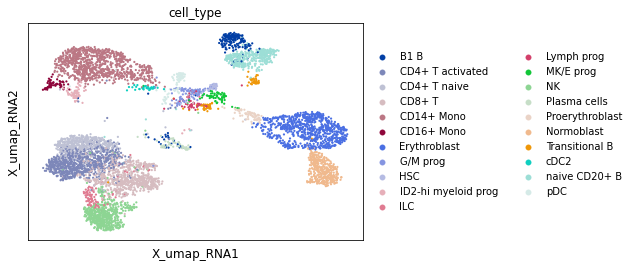

In [8]:
sc.pl.embedding(adata, basis="X_umap_RNA", 
                color=["cell_type"])

In [ ]:
# Check the coarse cell-types using some pan-marker genes
sc.pl.embedding(adata, basis="X_umap_RNA", 
                color=["CD3E-RNA","CD79B-RNA","KRT8-RNA",""],
                ncols=2)

### marker genes for T-cell subtypes

- 'CD4+ T activated': ['CD4', 'IL7R', 'TRBC2', 'ITGB1']
- 'CD4+ T naive': ['CD4', 'IL7R', 'TRBC2', 'CCR7']
- 'CD8+ T': ['CD8A', 'CD8B', 'GZMB', 'GZMA', 'CCL5', 'GZMK', 'GZMH', 'GZMA']
- 'T activation': ['CD69', 'CD38'] # CD69 much better marker!
- 'T naive': ['LEF1', 'CCR7', 'TCF7']
- 'ILC': ['ID2', 'PLCG2', 'GNLY', 'SYNE1']
- 'NK': ['GNLY', 'NKG7', 'CD247', 'GRIK4', 'FCER1G', 'TYROBP', 'KLRG1', 'FCGR3A']

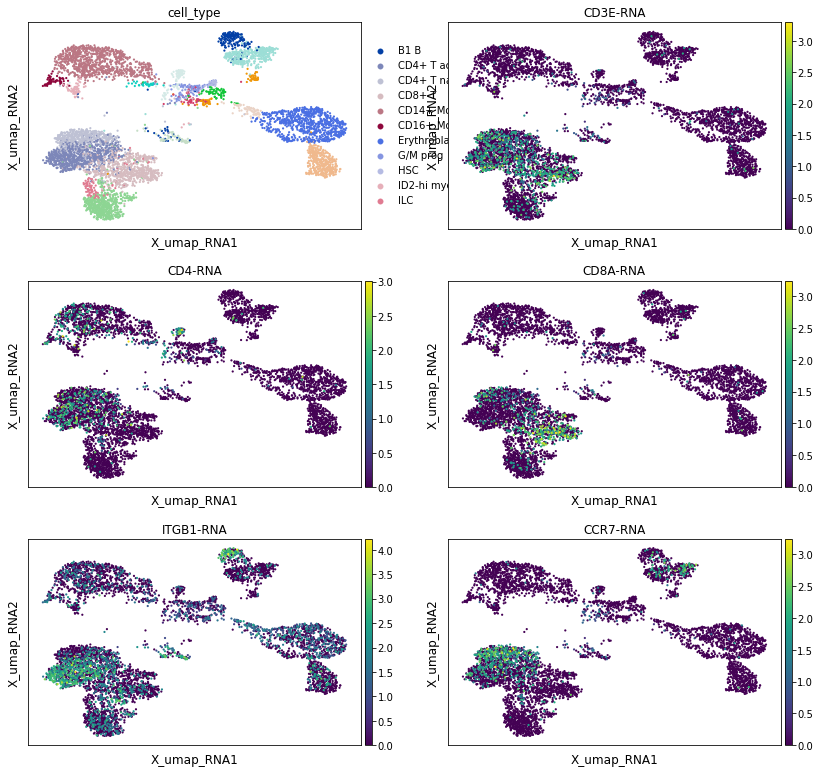

In [9]:
# dissection for the T-cell subtypes
sc.pl.embedding(adata, basis="X_umap_RNA", 
                color=["cell_type","CD3E-RNA","CD4-RNA","CD8A-RNA","ITGB1-RNA","CCR7-RNA"], 
                ncols=2)

In [ ]:
sc.pl.embedding(adata[adata.obs["cell_type"].isin([""])], basis="X_umap_RNA", 
                color=["cell_type","CD3E-RNA","CD4-RNA","CD8A-RNA","ITGB1-RNA","CCR7-RNA"], 
                ncols=2)

## Histogram for marker genes
(for selection of cells based on expression levels)


In [16]:
adata.obs["cell_type"].unique().to_list()

['CD4+ T naive',
 'Lymph prog',
 'CD4+ T activated',
 'Erythroblast',
 'CD8+ T',
 'naive CD20+ B',
 'CD14+ Mono',
 'HSC',
 'NK',
 'pDC',
 'B1 B',
 'G/M prog',
 'Normoblast',
 'CD16+ Mono',
 'MK/E prog',
 'ILC',
 'ID2-hi myeloid prog',
 'Proerythroblast',
 'cDC2',
 'Transitional B',
 'Plasma cells']

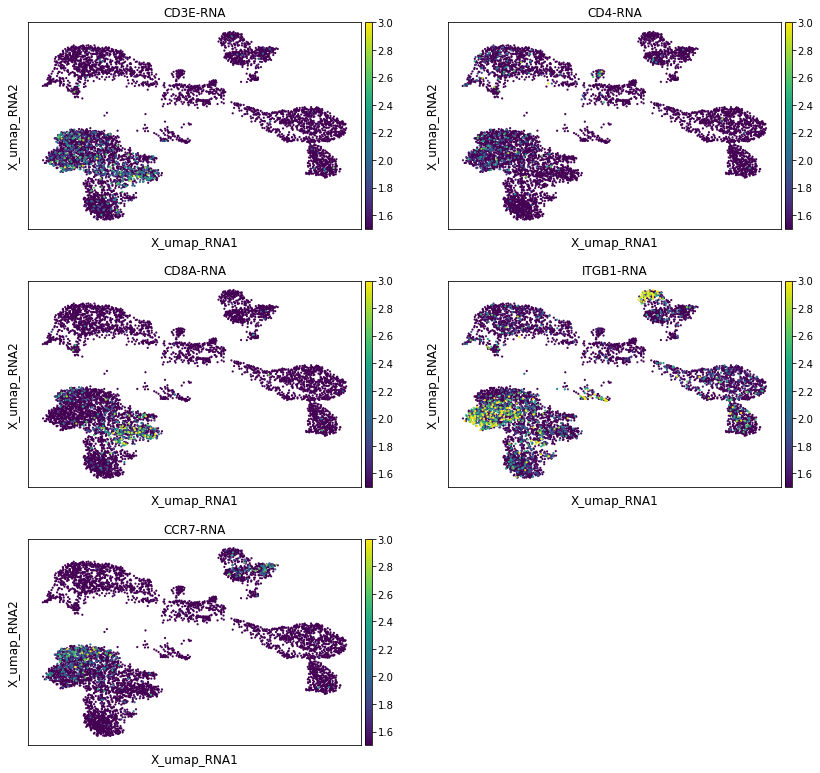

In [14]:
# dissection for the T-cell subtypes
# CD3E - T cells
# CD4 - CD4 T cells
# CD8A - CD8 T cells
# ITGB1 - activated T cells
# CCR7 - inactivated T cells
sc.pl.embedding(adata, basis="X_umap_RNA", 
                color=["CD3E-RNA","CD4-RNA","CD8A-RNA","ITGB1-RNA","CCR7-RNA"], 
                vmin=[1.5, 1.5, 1.5, 1.5, 1.5],
                vmax=[3.0, 3.0, 3.0, 3.0, 3.0],
                ncols=2)

In [ ]:
['CD4+ T naive',
 'Lymph prog',
 'CD4+ T activated',
 'Erythroblast',
 'CD8+ T',
 'naive CD20+ B',
 'CD14+ Mono',
 'HSC',
 'NK',
 'pDC',
 'B1 B',
 'G/M prog',
 'Normoblast',
 'CD16+ Mono',
 'MK/E prog',
 'ILC',
 'ID2-hi myeloid prog',
 'Proerythroblast',
 'cDC2',
 'Transitional B',
 'Plasma cells']

In [18]:
# read in the re-computed UMAP (sub-clustering visualization)
adata_sub = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/umap_RNA__umap_637e55e9.h5ad")
adata_sub

AnnData object with n_obs × n_vars = 2775 × 36271
    obs: 'name_0', 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'rna_ann', 'cell_type_RNA', 'cell_type_ATAC'
    var: 'name_0', 'assay', 'mean', 'variance'
    uns: 'N_umap_637e55e9_params'
    obsm: 'X_latent_pca', 'X_umap_637e55e9'
    layers: 'X'
    obsp: 'N_umap_637e55e9'

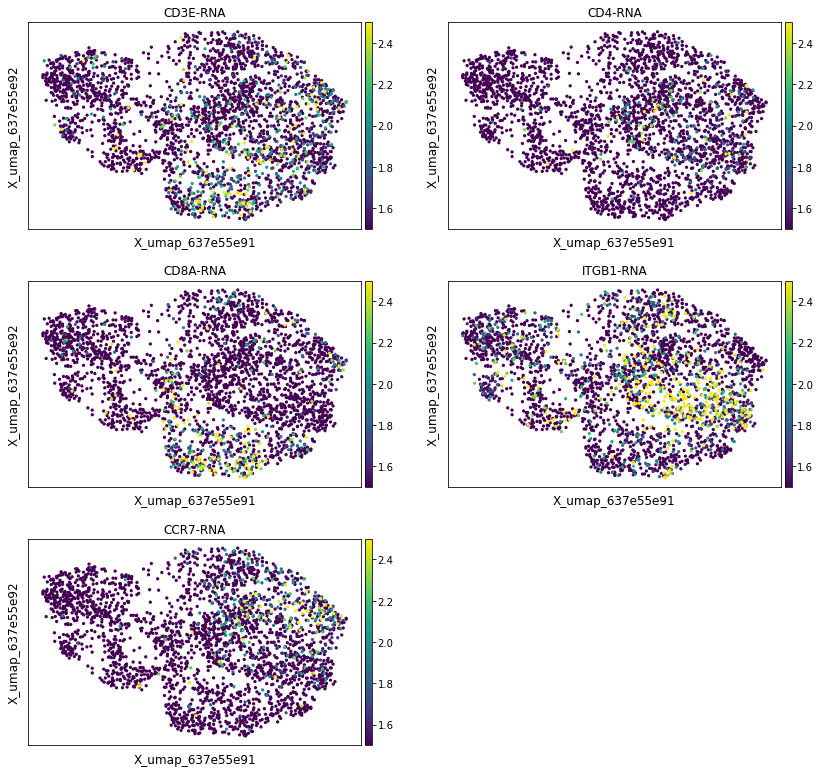

In [21]:
sc.pl.embedding(adata_sub, 
                basis="X_umap_637e55e9", 
                color=["CD3E-RNA","CD4-RNA","CD8A-RNA","ITGB1-RNA","CCR7-RNA"], 
                vmin=[1.5, 1.5, 1.5, 1.5, 1.5],
                vmax=[2.5, 2.5, 2.5, 2.5, 2.5],
                ncols=2)

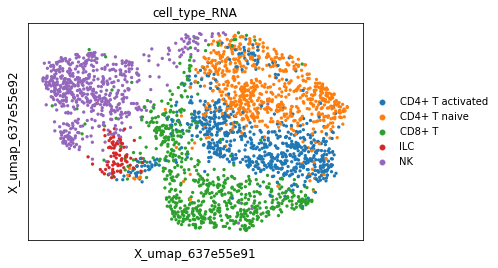

In [24]:
sc.pl.embedding(adata_sub, 
                basis="X_umap_637e55e9", 
                color="cell_type_RNA")

# Key parts for the figure generation

# Annotation done again using exCellxgene - coarse/fine level for T cells and progenitor population only

- last updated: 1/3/2023


In [4]:
adata = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/s1d1_rna_processed_annotated_forViz.h5ad")
adata

AnnData object with n_obs × n_vars = 6224 × 17739
    obs: 'name_0', 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'pseudotime_order_GEX', 'manual_annotation', 'annotation_for_visualization'
    var: 'name_0', 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'mean', 'variance'
    obsm: 'X_latent_pca', 'X_pca', 'X_umap'
    layers: 'X', 'counts'
    obsp: 'N_pca', 'N_umap'

In [5]:
adata.obs["annotation_for_visualization"].unique()

['unassigned', 'T_cells']
Categories (2, object): ['T_cells', 'unassigned']

In [6]:
adata.obs["manual_annotation"].unique()

['unassigned', 'CD4+T', 'CD8+T', 'Lymph_prog', 'NK', 'HSC', 'MK_E_prog', 'pDC', 'G_M_prog']
Categories (9, object): ['CD4+T', 'CD8+T', 'G_M_prog', 'HSC', ..., 'MK_E_prog', 'NK', 'pDC', 'unassigned']

In [7]:
adata[adata.obs["annotation_for_visualization"]=="T_cells"]

View of AnnData object with n_obs × n_vars = 2775 × 17739
    obs: 'name_0', 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'pseudotime_order_GEX', 'manual_annotation', 'annotation_for_visualization'
    var: 'name_0', 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'mean', 'variance'
    obsm: 'X_latent_pca', 'X_pca', 'X_umap'
    layers: 'X', 'counts'
    obsp: 'N_pca', 'N_umap'

In [26]:
adata_test = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/umap__umap_638f9aee.h5ad")
adata_test

AnnData object with n_obs × n_vars = 404 × 17739
    obs: 'name_0', 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'pseudotime_order_GEX', 'manual_annotation'
    var: 'name_0', 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'mean', 'variance'
    uns: 'N_umap_638f9aee_params'
    obsm: 'X_latent_pca', 'X_umap_638f9aee'
    layers: 'X', 'counts'
    obsp: 'N_umap_638f9aee'

In [75]:
adata.obs["annotation_for_visualization"].cat = adata.obs["annotation_for_visualization"].cat.add_categories("progenitors")
adata.obs["annotation_for_visualization"].cat

TAGTTGTCACCCTCAC-1    unassigned
CTATGGCCATAACGGG-1    unassigned
CCGCACACAGGTTAAA-1       T_cells
TCATTTGGTAATGGAA-1       T_cells
ACCACATAGGTGTCCA-1    unassigned
                         ...    
AGACCCGGTTATCCTA-1       T_cells
GACCTAAGTGCCTCAC-1    unassigned
AGCTCATAGCTATATG-1       T_cells
TACGTACAGGAAACTG-1       T_cells
GGTTTCTGTTTATCTG-1       T_cells
Name: annotation_for_visualization, Length: 6224, dtype: category
Categories (3, object): ['T_cells', 'unassigned', 'progenitors']

In [ ]:
# A tip on how to play with the categorical data/order: From https://stackoverflow.com/questions/54422643/how-can-i-add-new-category-in-a-categorical-variables-after-a-qcut
# cat = df['Score_pr'].cat.categories.tolist()
# cat = cat[:-1]
# cat.insert(0, '0')
# series = pd.Series(cat)
# df['Score_pr'] = df['Score_pr'].cat.reorder_categories(series)

In [91]:
adata.obs.loc[adata.obs_names.isin(adata_test.obs_names),"annotation_for_visualization"] = 'T_cells'

## Let's just generate the figure panels without re-defining the adata.obs values

In [69]:
adata.uns

OverloadedDict, wrapping:
	OrderedDict([('log1p', {'base': None}), ('manual_annotation_colors', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#bcbd22', '#A9A9A9'])])
With overloaded keys:
	['neighbors'].

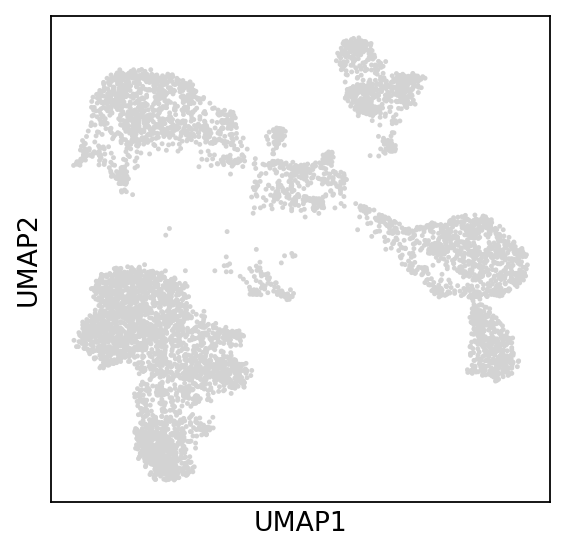

In [86]:
sc.pl.umap(adata, save="_basic_no_color.pdf")

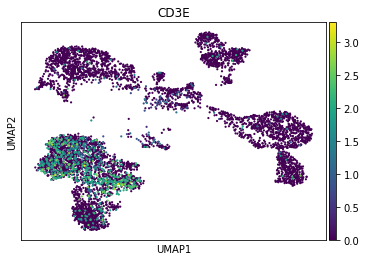

In [22]:
sc.pl.umap(adata, color="CD3E", save="_CD3E_T_cells.pdf")

In [16]:
adata.X = adata.layers["counts"]
adata.X.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
np.sum(adata.X.todense(),1)

matrix([[1502.],
        [1648.],
        [7213.],
        ...,
        [1971.],
        [ 920.],
        [3018.]], dtype=float32)

In [18]:
# log-normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [19]:
np.sum(np.expm1(adata.X.todense()),1)

matrix([[10000.   ],
        [10000.   ],
        [10000.001],
        ...,
        [10000.   ],
        [10000.   ],
        [ 9999.998]], dtype=float32)

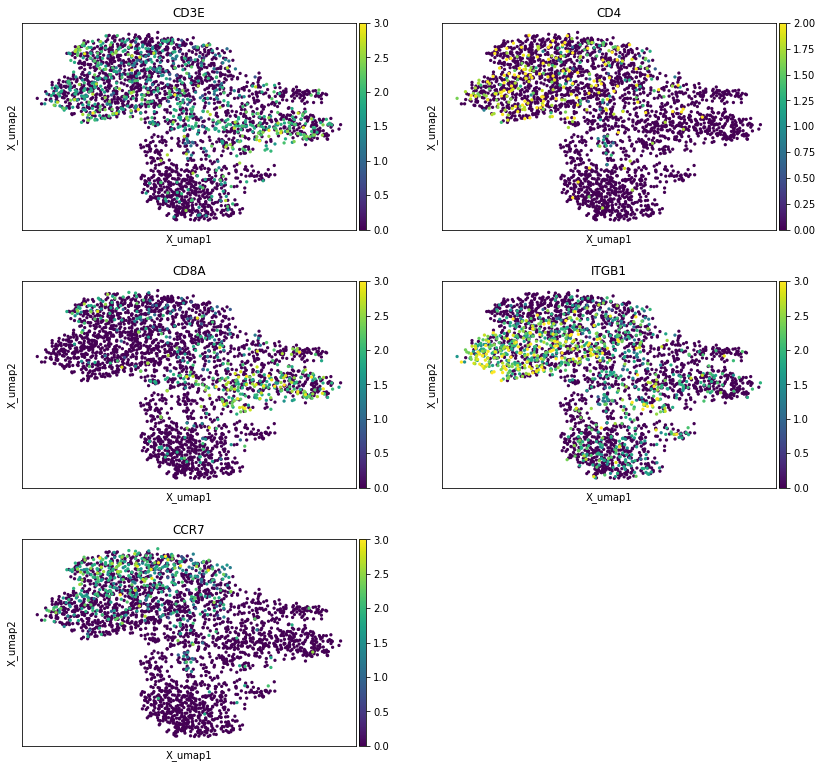

In [24]:
# dissection for the T-cell subtypes
# CD3E - T cells
# CD4 - CD4 T cells
# CD8A - CD8 T cells
# ITGB1 - activated T cells
# CCR7 - inactivated T cells
sc.pl.embedding(adata[adata.obs["annotation_for_visualization"]=="T_cells"], 
                basis="X_umap", 
                color=["CD3E","CD4","CD8A","ITGB1","CCR7"], 
                vmin=[0, 0, 0, 0, 0],
                vmax=[3, 2, 3, 3, 3],
                ncols=2)

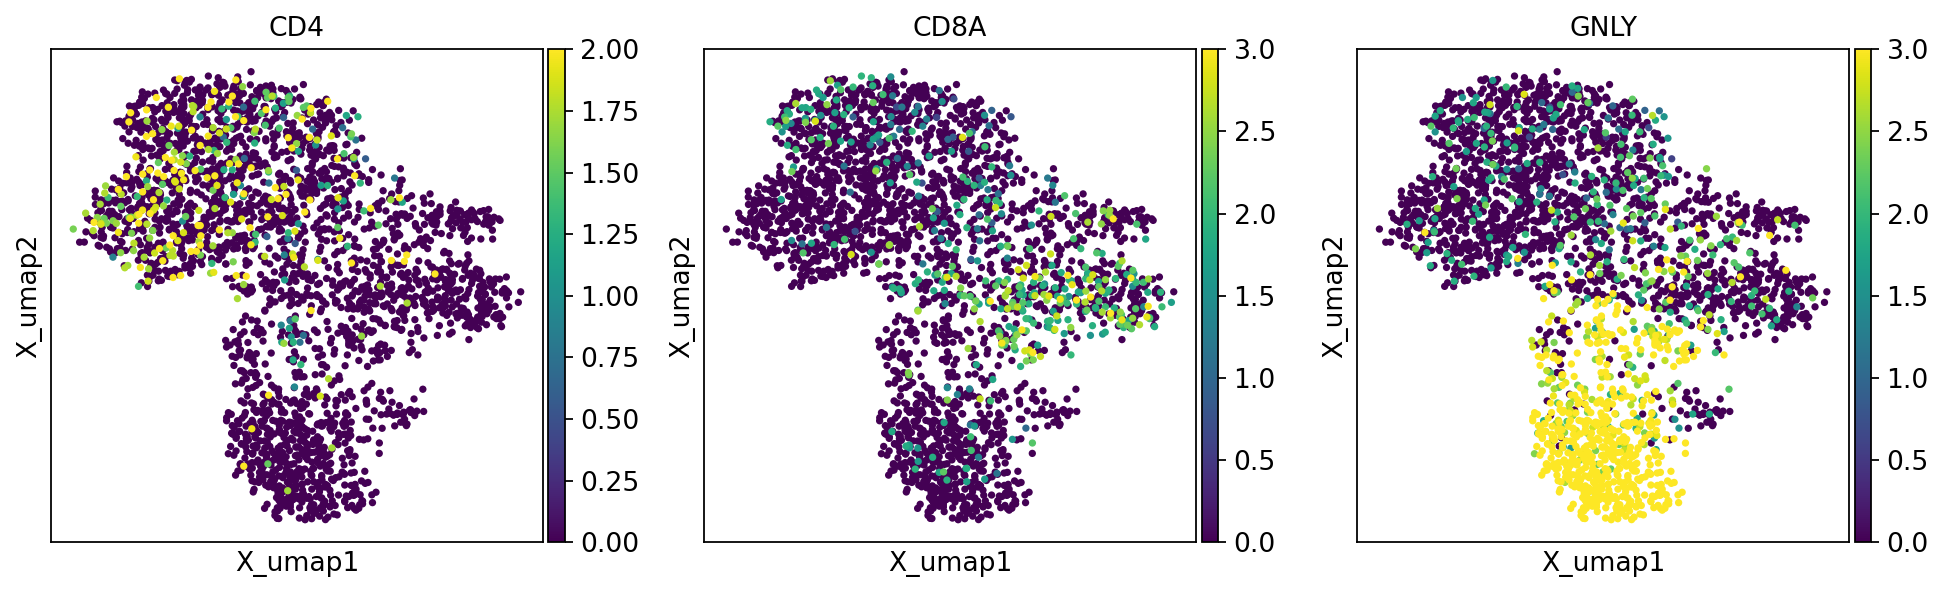

In [58]:
# dissection for the T-cell subtypes
# CD3E - T cells
# CD4 - CD4 T cells
# CD8A - CD8 T cells
# GNLY - NK cells
sc.set_figure_params(fontsize=12)
sc.pl.embedding(adata[adata.obs["annotation_for_visualization"]=="T_cells"], 
                basis="X_umap", 
                color=["CD4","CD8A","GNLY"], 
                vmin=[0, 0, 0],
                vmax=[2, 3, 3],
                ncols=3,
                save="_T_cell_subtype_markers.pdf")

In [27]:
mpl.rcParams["image.cmap"]

'viridis'

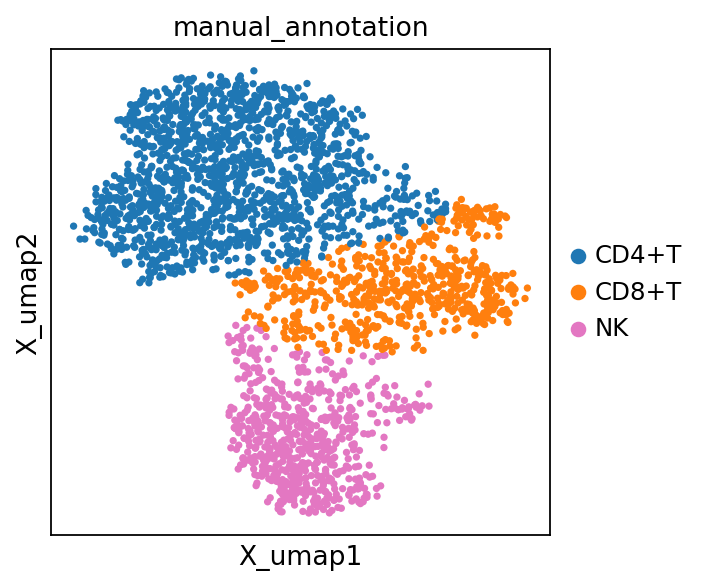

In [72]:
# dissection for the T-cell subtypes
sc.pl.embedding(adata[adata.obs["annotation_for_visualization"]=="T_cells"], 
                basis="X_umap", 
                color="manual_annotation",
                save="_T_cell_subtypes_annotated.pdf")

## Checking the progenitor cluster at the center 
-> need sub-clustering for finer resolution in the UMAP embedding space

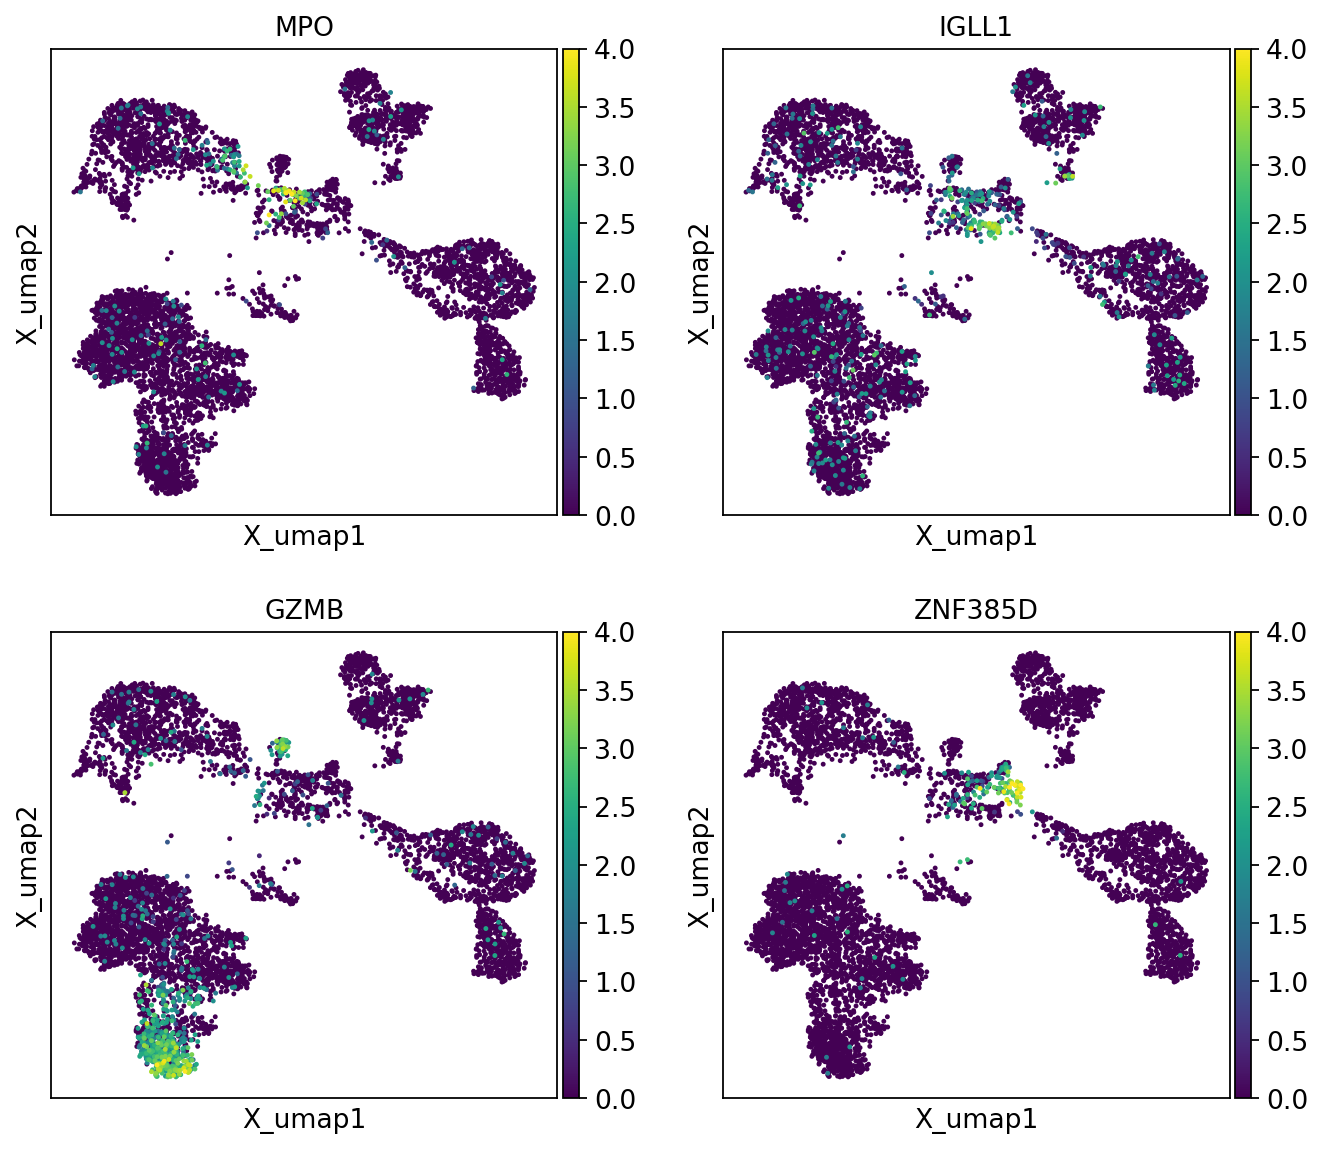

In [61]:
# Checking the progenitor population
sc.pl.embedding(adata, 
                basis="X_umap", 
                color=["MPO","IGLL1","GZMB","ZNF385D"], 
                vmin=[0, 0, 0, 0],
                vmax=[4, 4, 4, 4],
                ncols=2,
                save="_progenitor_subtype_markers.pdf")

In [39]:
adata_test = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/umap__umap_638f9aee.h5ad")
adata_test

AnnData object with n_obs × n_vars = 404 × 17739
    obs: 'name_0', 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'pseudotime_order_GEX', 'manual_annotation'
    var: 'name_0', 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'mean', 'variance'
    uns: 'N_umap_638f9aee_params'
    obsm: 'X_latent_pca', 'X_umap_638f9aee'
    layers: 'X', 'counts'
    obsp: 'N_umap_638f9aee'

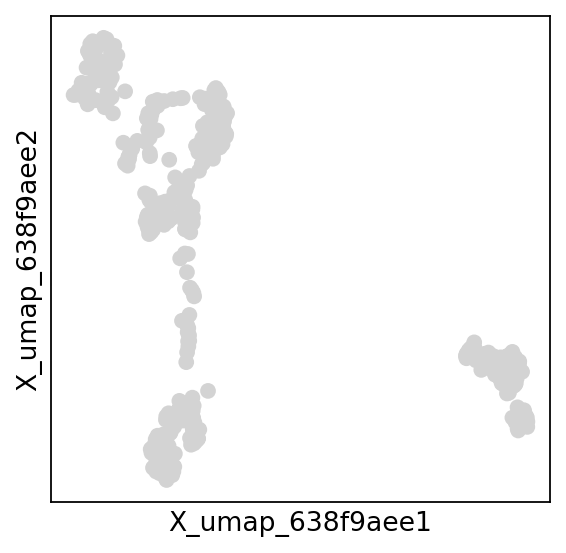

In [63]:
# Checking the progenitor population
sc.pl.embedding(adata_test, 
                basis="X_umap_638f9aee",
                save="_progenitor_pop_sub_clustering.pdf",
                size=200)

In [51]:
adata_test.obs["cells"] = "progenitors"
adata_test

AnnData object with n_obs × n_vars = 404 × 17739
    obs: 'name_0', 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'pseudotime_order_GEX', 'manual_annotation', 'cells'
    var: 'name_0', 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'mean', 'variance'
    uns: 'N_umap_638f9aee_params', 'cells_colors'
    obsm: 'X_latent_pca', 'X_umap_638f9aee'
    layers: 'X', 'counts'
    obsp: 'N_umap_638f9aee'

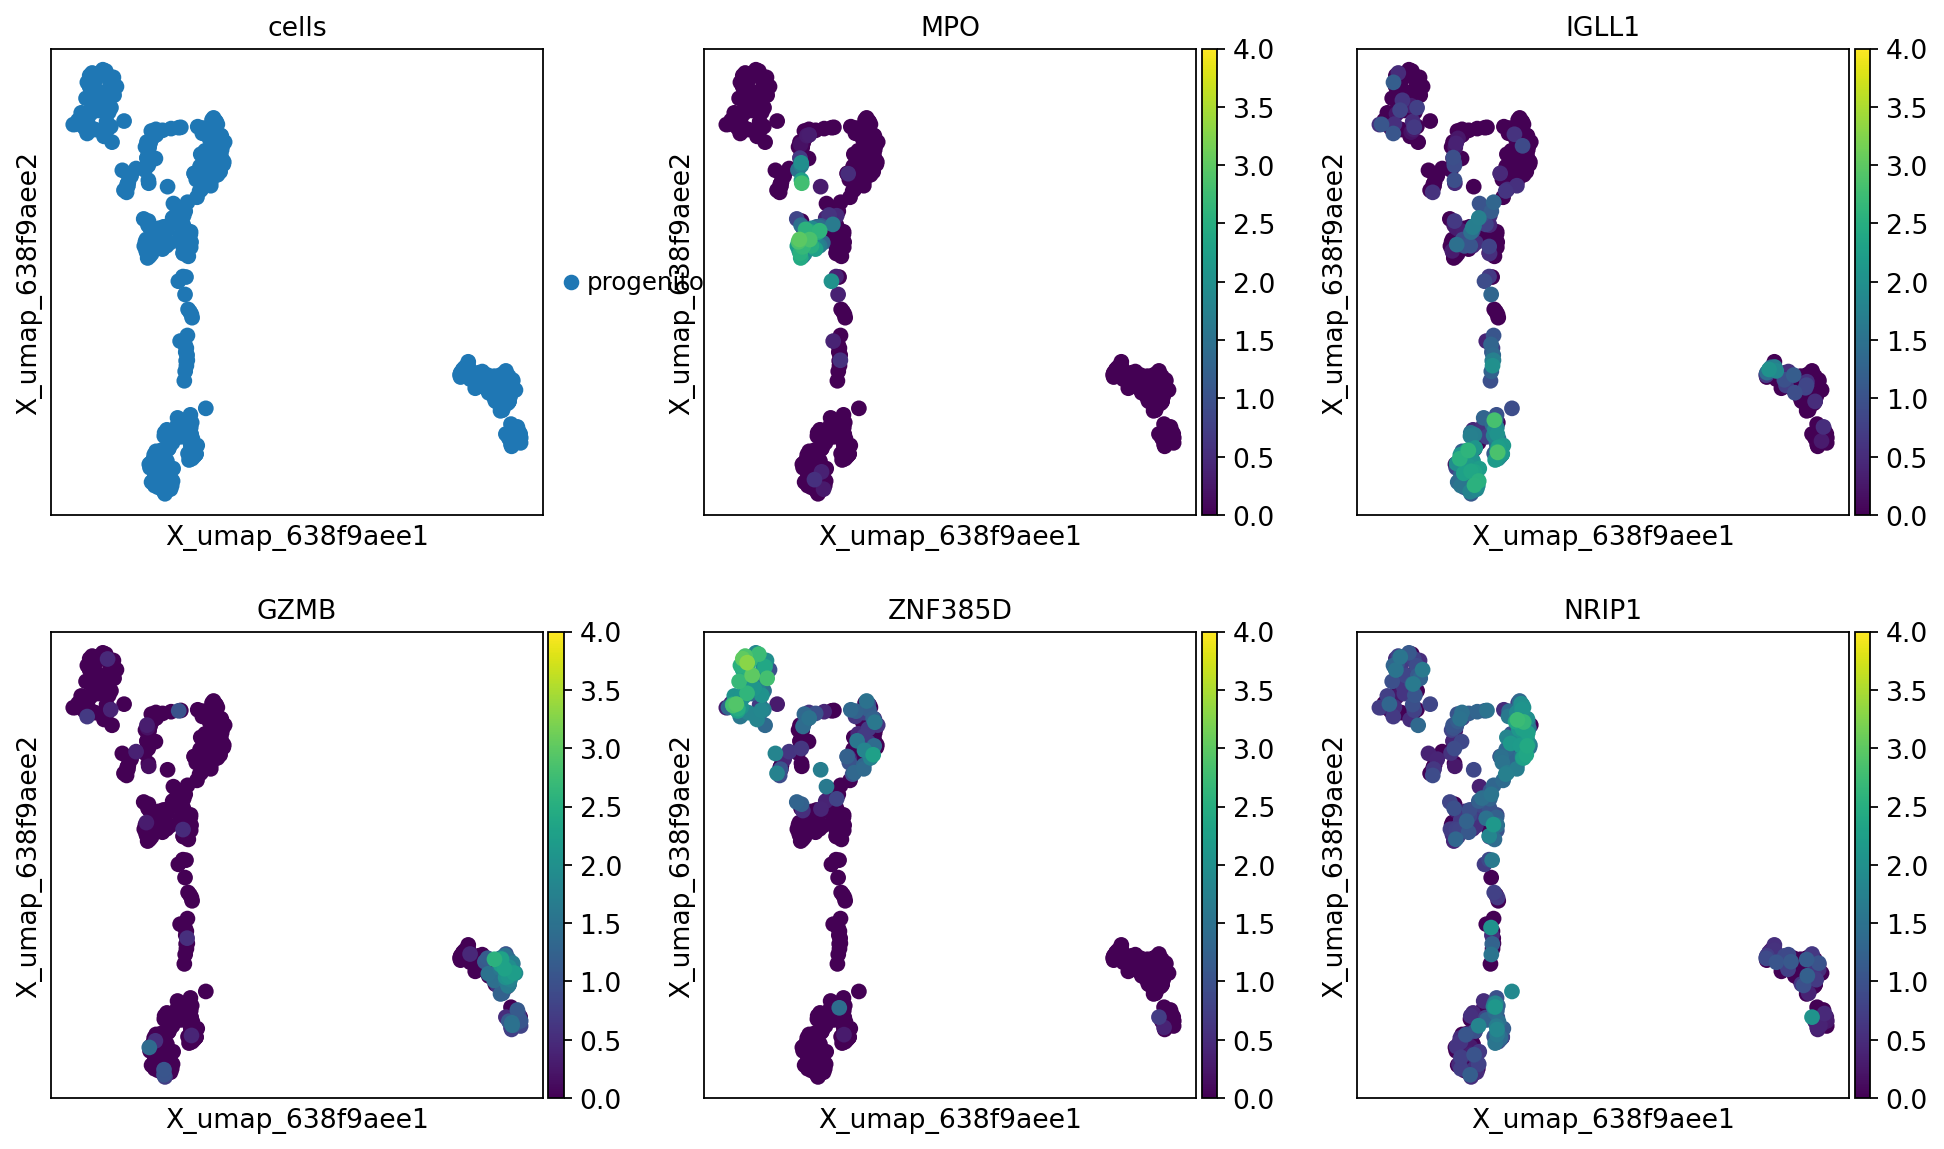

In [65]:
# Checking the progenitor population
sc.pl.embedding(adata_test, 
                basis="X_umap_638f9aee", 
                color=["cells","MPO","IGLL1","GZMB","ZNF385D","NRIP1"], 
                vmin=[0,0, 0, 0, 0, 0],
                vmax=[0,4, 4, 4, 4, 4],
                ncols=3,
                save="_progenitor_subtype_markers_sub_clustered.pdf",
                size=200)

In [79]:
adata_test.obs.manual_annotation.unique()

['Lymph_prog', 'HSC', 'MK_E_prog', 'pDC', 'G_M_prog']
Categories (5, object): ['G_M_prog', 'HSC', 'Lymph_prog', 'MK_E_prog', 'pDC']

In [75]:
adata_test.uns["manual_annotation_colors"]

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

In [83]:
# redefine the color dict for the manual_annotation
# Note: We can always come back and change the color scheme. Maybe Ask Alejandro if he has a preferred set of colors
# It would be challenging to make this consistent with exCellxgene colorset, but definitely an option to try.
adata_test.uns["manual_annotation_colors"] = ['#2ca02c', '#d62728', '#9467bd', '#8c564b', '#bcbd22']



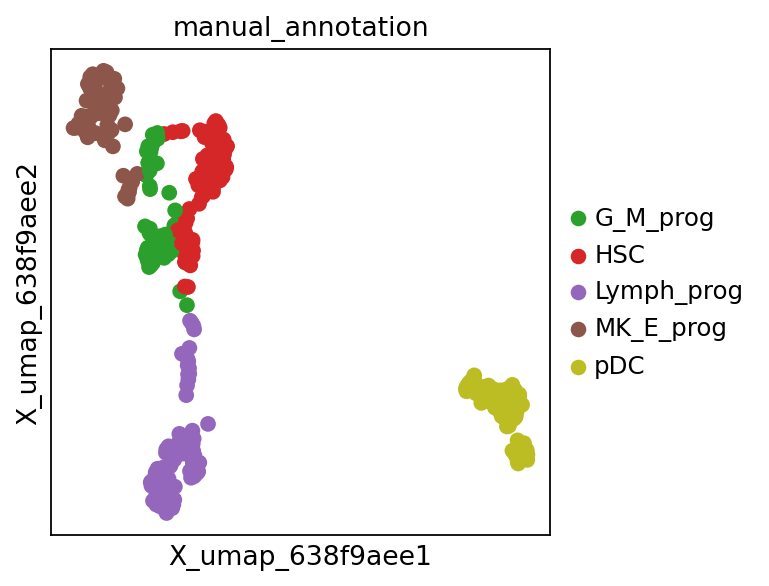

In [84]:
# Checking the progenitor population
sc.pl.embedding(adata_test, 
                basis="X_umap_638f9aee", 
                color=["manual_annotation"],
                save="_progenitor_subclustered_fine_annotated.pdf",
                size=200)

In [ ]:
# Checking the progenitor population
sc.pl.embedding(adata, 
                basis="X_umap", 
                color=["MPO","IGLL1","GZMB","ZNF385D"], 
                vmin=[0, 0, 0, 0],
                vmax=[4, 4, 4, 4],
                ncols=2)

In [97]:
adata.obs["manual_annotation"].unique()

['unassigned', 'CD4+T', 'CD8+T', 'Lymph_prog', 'NK', 'HSC', 'MK_E_prog', 'pDC', 'G_M_prog']
Categories (9, object): ['CD4+T', 'CD8+T', 'G_M_prog', 'HSC', ..., 'MK_E_prog', 'NK', 'pDC', 'unassigned']

In [101]:
adata.obs["manual_annotation"].cat.categories

Index(['CD4+T', 'CD8+T', 'G_M_prog', 'HSC', 'Lymph_prog', 'MK_E_prog', 'NK',
       'pDC', 'unassigned'],
      dtype='object')

In [102]:
adata.uns

#['#1f77b4', '#ff7f0e', '#2ca02c', '#A9A9A9']

In [123]:
adata.obs.loc[adata.obs_names.isin(adata_test.obs_names)]["annotation_for_visualization"] = "progenitors"
adata

/tmp/ipykernel_1318712/580462805.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.loc[adata.obs_names.isin(adata_test.obs_names)]["annotation_for_visualization"] = "progenitors"


AnnData object with n_obs × n_vars = 6224 × 17739
    obs: 'name_0', 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'pseudotime_order_GEX', 'manual_annotation', 'annotation_for_visualization'
    var: 'name_0', 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'mean', 'variance'
    uns: 'manual_annotation_colors'
    obsm: 'X_latent_pca', 'X_pca', 'X_umap'
    layers: 'X', 'counts'
    obsp: 'N_pca', 'N_umap'

In [125]:
adata.obs["annotation_for_visualization"].unique()

['unassigned', 'T_cells']
Categories (2, object): ['T_cells', 'unassigned']

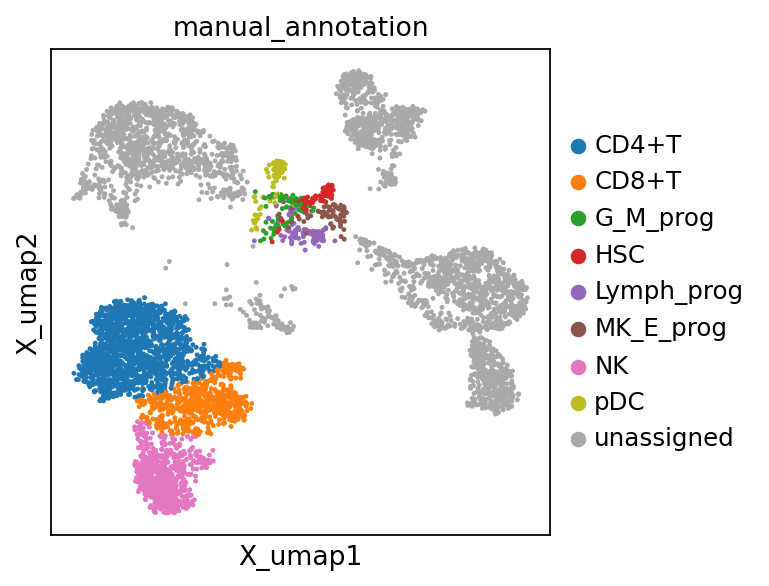

In [85]:
sc.pl.embedding(adata, basis="X_umap",color="manual_annotation",
                save="_T_cells_progenitors_fine_annotated.pdf")

In [82]:
adata[adata.obs.index.isin(adata_test.obs.index)].uns["manual_annotation_colors"]

array(['#2ca02c', '#d62728', '#9467bd', '#8c564b', '#bcbd22'], dtype='<U7')